## Session 2: An introduction to Qiskit and to IBM's interface

In [16]:
# A classical simulator of quantum circuits
from qiskit_aer import AerSimulator

# Class QuantumCircuit, with methods (functions) to define quantum circuits
from qiskit import QuantumCircuit

# A function yielding a histogram with the probabilities of each of the eigenstates taken by the measured qubits
from qiskit.visualization import plot_histogram

# Class Statvector, to retrieve the state of the circuit
from qiskit.quantum_info import Statevector

# Class PhaseGate, essential for quantum Fourier transform
from qiskit.circuit.library import PhaseGate

# Other usual imports
import numpy as np
import matplotlib.pyplot as plt

# Printing precision
np.set_printoptions(precision=2)

**Sections 1 and 2 walk us through the basics of Qiskit.**

### **3. Executing circuits**

<font color=teal>**Question:** Why does the histogram have only one bar corresponding to |1>  ? </font>

**Answer:** Because the qubit is initialized to the state $|1\rangle$, it has no component along $|0\rangle$.

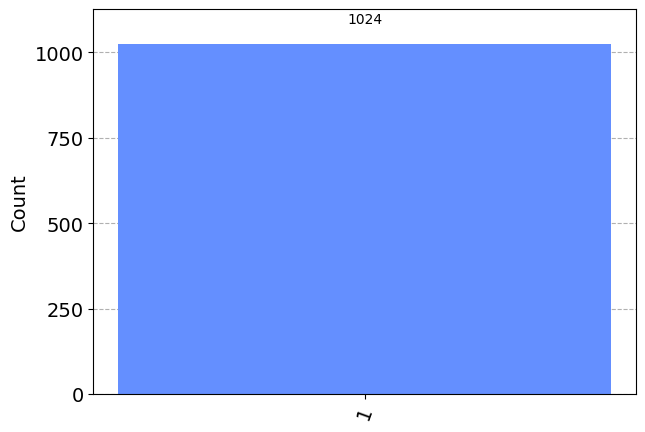

In [17]:
sim = AerSimulator()
qc11 = QuantumCircuit(1,1) # circuit with 1 qubit y 1 classical bit
state_1 = [0,1] # this would be |1>, trivially normalized
qc11.initialize(state_1,0)
qc11.measure(0,0)
resultmeasure = sim.run(qc11).result() # Execute the circuite qc11 in the simulator
counts = resultmeasure.get_counts() # Results of the measurements
plot_histogram(counts) # Plot a histogram with that variable

#### **4. Generation of truly random numbers with a quantum computer**

<font color= teal> Question: Can you write in a piece of paper the initial state in the second line of the next paragraph?</font>

**Answer:** Let $|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ in the computational, single-qubit basis &mdash; the initial state is $|+\rangle\otimes|+\rangle\otimes|+\rangle\otimes|+\rangle$. In the $\{|n\rangle\}_{n=0}^{15}$ basis, where $|n\rangle$ is the binary representation of n, taking the digits $0$ or $1$ to be qubits $|0\rangle$, $|1\rangle$ tensored with each other, $|\mathrm{init}\rangle=\frac{1}{4}\sum\limits_{n=0}^{15}|n\rangle$. Indeed, this is what the `draw` method shows, an equal superposition of states, which is what we would need to simulate a uniform probability distribution.

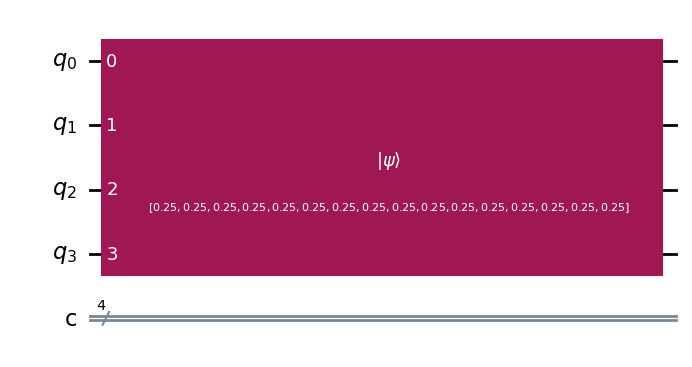

In [18]:
qrng = QuantumCircuit(4,4)
init_state = np.kron([1,1],np.kron([1,1],np.kron([1,1],[1,1]))) # Kron is a Python command for Cartesian (or Kronecker) products
init_state_normal = init_state/np.linalg.norm(init_state)
qrng.initialize(init_state_normal,[0,1,2,3])
qrng.draw(output='mpl')

We may encapsulate random number generation in the following function:

In [19]:
def QRNG(N_qubits): #a quantum random number generator
    qrng = QuantumCircuit(N_qubits)
    qrng.h(range(N_qubits))
    qrng.measure_all()
    result = sim.run(qrng, shots=1).result()
    counts = result.get_counts()
    return int(*counts, 2)

<font color=teal> Question: run the circuit a few times and write down the number obtained </font>

**Answer:** After running it a few times we obtained the following list of numbers:
`14, 3, 5, 9, 8, 12, 1, 10, 6, 11, 2, 6, 0, 10, 7, 13, 6, 14, 5, 1, 0, 14, 4`


In [20]:
QRNG(4)

2

<font color=teal> Question: Write a loop that generates 32 random numbers and plot a histogram with their distribution. </font>

**Answer:**

Text(0.5, 1.0, 'Quantum RNG distribution')

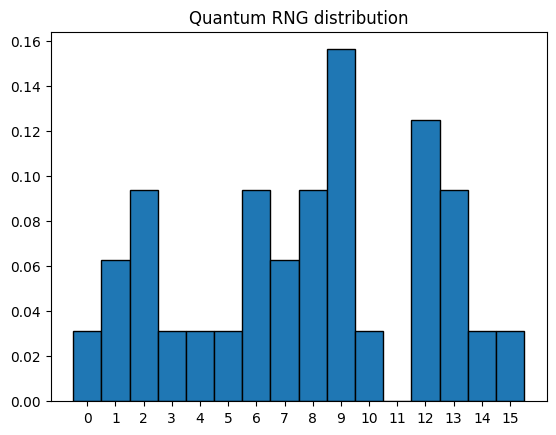

In [21]:
N_qubits = 4
N = 32
distrib = [QRNG(N_qubits) for _ in range(N)]

dim = 2**N_qubits
plt.hist(distrib, bins=range(dim+1), density=True, align='left', edgecolor='black', linewidth=1)
plt.xticks(ticks=range(dim), labels=range(dim))
plt.title('Quantum RNG distribution')

<font color=teal> Question: Write down in a piece of paper all the methods that you have learned here </font>

**Answer:** We have learnt the following methods:

Applied to a `QuantumCircuit`
- `draw`: Plots a diagram of the circuit.
- `initialize`: Given a normalised statevector of the appropriate dimension, prepares the circuit or subset of the circuit in that state.
- `measure`: Collapses a particular qubit and stores result in a particular cbit.
- `measure_all`: Adds a cbit for each qubit in the circuit and measures all.

Applied to an `AerSimulator`
- `run`: Runs `QuantumCircuit` on the Aer backend and returns asynchronous simulation job.

Applied to an `AerJob`
- `result`: Awaits job result.

Applied to a `Result`
- `get_counts`: Gets the histogram data of a quantum simulation.

#### **5. Quantum Fourier Transform**

The discrete Fourier transform (DFT) changes the elements of a computational basis $B$ to the Fourier basis $F(B)$ according to the formula

$$
\left|j\right\rangle_{B}\rightarrow \left|j\right\rangle_{F(B)} =  \frac{1}{\sqrt{N}}\sum^{N-1}_{k=0} e^{2\pi i j k /N}\left|k\right\rangle_{B}
$$

It is worth noting that the elements of the computational basis in a $2^n$ dimensional Hilbert space may be labeled by the number $j$, or by its representation as an $n$-bit binary string,

$$
j \equiv j_1 j_2 ... j_n \equiv \sum\limits_{\ell=1}^{n} j_\ell 2^{n-\ell}
$$

, i.e. we can choose the basis states to be the tensor products of the single-qubit basis states $|j_\ell\rangle_B$, $j_\ell\in\{0,1\}$.

We call the application of the DFT to a quantum state the quantum Fourier transform (QFT), and it has a computationally efficient alternative formula:

$$
QFT_n |j\rangle_{B} = \frac{1}{\sqrt{N}}\sum^{N-1}_{k=0} e^{2\pi i j k /N}\left|k\right\rangle_{B} = 
\frac{1}{2^{n/2}}\sum^{2^n-1}_{k=0} e^{2\pi i j k 2^{-n}}\left|k\right\rangle_{B} = 
$$

$$
= \frac{1}{2^{n/2}}\sum^{1}_{k_1=0}\sum^{1}_{k_2=0}...\sum^{1}_{k_n=0}
e^{2\pi i j \sum\limits_{\ell=1}^{n} k_\ell 2^{-\ell}}\left|k_1 k_2 ... k_n\right\rangle_{B} =
$$

$$
= \frac{1}{2^{n/2}}\sum^{1}_{k_1=0}e^{2\pi i j k_1 2^{-1}}|k_1\rangle_B
\sum^{1}_{k_2=0}e^{2\pi i j k_2 2^{-2}}|k_2\rangle_B... 
\sum^{1}_{k_n=0}e^{2\pi i j k_n 2^{-n}}|k_n\rangle_B = 
\frac{1}{2^{n/2}} \bigotimes\limits_{m=1}^{n}\sum\limits_{k_m=0}^1 e^{2\pi i j k_m 2^{-m}}|k_\ell\rangle_B = 
$$

$$
= \frac{1}{2^{n/2}} \bigotimes\limits_{m=1}^{n}\left(|0\rangle + e^{2\pi i j 2^{-m}}|1\rangle \right) = 
\frac{1}{2^{n/2}} \bigotimes\limits_{m=1}^{n}\left(|0\rangle + e^{2\pi i \sum\limits_{\ell=1}^n j_\ell 2^{n-\ell-m}}|1\rangle \right) 
$$

Since integer rotations in the complex plane don't add any phase, the expression for the QFT finally simplifies to

$$
QFT_n |j\rangle_{B} = \frac{1}{2^{n/2}} \bigotimes\limits_{m=1}^{n}\left(|0\rangle + e^{2\pi i \sum\limits_{\ell=1}^{m} j_{n+\ell-m} 2^{-\ell}}|1\rangle \right) 
$$

**In the exercise notebook we're walked through programming the QFT:**<font color="teal">

The operation

$$\alpha |0\rangle + \beta | 1 \rangle \rightarrow  \alpha | 0 \rangle +\beta e^{2\pi i\ /\ 2^k} | 1 \rangle $$

Can be represented in matrix form as

$$R_k = \begin{pmatrix}
1 & 0 \\
0 & e^{2\pi i /2^k}
\end{pmatrix},$$

while one of the basic transformations in the Qiskit package is *PhaseGate*, with matrix representation

$$\text{PhaseGate}(\phi) = \begin{pmatrix}
1 & 0 \\
0 & e^{i\phi}
\end{pmatrix}.$$

Hence,

**Question 5.1.** Check that the following function implements the $R_k$ transformation: </font>

**Answer:**

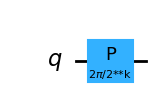

In [22]:
def R(k):
    return PhaseGate((2.*np.pi)/pow(2,k))

# Indeed, we can plot R(k) ∀ k with a parametrised circuit.
# We see the transformation is implemented as desired.
from qiskit.circuit import Parameter
k = Parameter('k')
ans = QuantumCircuit(1)
ans.append(R(k),[0])
ans.draw(output='mpl')

We can try this gate and compare it to what we should get for a couple of values of $k$

In [23]:
maxK = 6
result = [0] * maxK
expected = [0] * maxK

for k in range(maxK):
  # Rk circuit
  circ1 = QuantumCircuit(1)
  circ1.x(0) # Initialise to |1>
  circ1.append(R(k), [0]) # Apply Rk
  psi = Statevector(circ1)
  result[k] = psi[1]
  # Expected phase
  expected[k] = np.exp(2*np.pi*(1j) / 2**k)

print(
f'''
What we got        {np.array(result)}
What we should get {np.array(expected)}''')


What we got        [ 1.00e+00-2.45e-16j -1.00e+00+1.22e-16j  6.12e-17+1.00e+00j
  7.07e-01+7.07e-01j  9.24e-01+3.83e-01j  9.81e-01+1.95e-01j]
What we should get [ 1.00e+00-2.45e-16j -1.00e+00+1.22e-16j  6.12e-17+1.00e+00j
  7.07e-01+7.07e-01j  9.24e-01+3.83e-01j  9.81e-01+1.95e-01j]


We can appreciate the $R_k$ gate performs the previously described transformation perfectly, although there may be some precision error in both calculations.

**In sections 5.1-5.2 we're walked through programming a 3-register QFT.** At the step at which we accomplish<font color="teal">

$$| j_1j_2j_3\rangle \rightarrow | \psi_1\rangle = \frac{1}{\sqrt{2}}\left(\left|0\right\rangle+e^{2\pi i (j_1/2 +j_2/4)}\left|1\right\rangle\right)\otimes | j_2j_3\rangle.$$

</font>

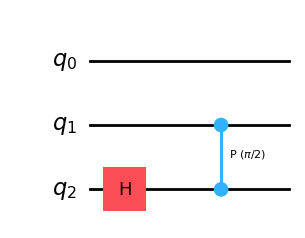

In [24]:
qft_circuit = QuantumCircuit(3, name = 'QFT')
qft_circuit.h(2)
qft_circuit.draw()
qft_circuit.append(R(2).control(),[2,1])
qft_circuit.draw(output='mpl')

<font color="teal">**Question 5.2** Write the state resulting from applying that transformation to the initial ket
 $| 010\rangle$.
    Check, with the </font><font color="blue">Statevector</font> <font color="teal">
    class that the circuit generates the correct output.</font>
    
**Answer:** We may compute the resulting state by hand. It is $\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)\otimes|10\rangle$ or, in the binary basis, $\frac{1}{\sqrt{2}}(|2\rangle+i|6\rangle)$.

In [25]:
init_state = np.zeros(8)
init_state[2] = 1
qc = QuantumCircuit(3)
qc.initialize(init_state, range(3))
qc.append(qft_circuit, range(3))
phians = Statevector(qc)

# By printing the result, this checks out
phians

Statevector([0.00e+00+0.j  , 0.00e+00+0.j  , 7.07e-01+0.j  ,
             0.00e+00+0.j  , 0.00e+00+0.j  , 0.00e+00+0.j  ,
             4.33e-17+0.71j, 0.00e+00+0.j  ],
            dims=(2, 2, 2))


#### <font color="teal"> 5.3 QFT full exercise</font>

<font color="teal"> Please implement now the Quantum Fourier Transform as a gate acting over 5 qubits.  Apply this gate to the following states.

$$ |\phi_1\rangle = \frac{1}{2^{5/2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle-\left|1\right\rangle\right)$$
$$ |\phi_2\rangle = \frac{1}{2^{5/2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle-\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)$$
$$ |\phi_3\rangle = \frac{1}{2^{5/2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle-\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)$$
$$ |\phi_4\rangle = \frac{1}{2^{5/2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle-\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)\left(\left|0\right\rangle+\left|1\right\rangle\right)$$
    
Briefly comment on the results.  </font>

**Answer:** A QFT circuit implements the following transformation:

$$
|j_1j_2...j_n\rangle_B\rightarrow \frac{1}{2^{n/2}}
\left(|0\rangle + e^{2\pi i \frac{j_n}{2}}|1\rangle \right) 
\left(|0\rangle + e^{2\pi i (\frac{j_{n-1}}{2}+\frac{j_n}{4})}|1\rangle \right)
... 
\left(|0\rangle + e^{2\pi i (\frac{j_1}{2}+...+\frac{j_n}{2^n})}|1\rangle \right) 
$$

As we can see, the value of qubit 1 ($j_n$) appears in every term (and $j_{n-1}$ appears in every term up to the penultimate, so on and so forth). This implies we have to act on the least significant bit last, so as to not modify $j_n$ while we still need its value (likewise with $j_{n-1}$, etc.).

On the other hand, the least significant half of the transformed bits require information from bits more significant than them, so we have to apply the QFT from least significant bit to most significant bit.

The way to solve this conundrum is to store the transformed qubits in reverse order, and to afterwards apply a series of swaps to recover the proper ordering. We can apply the required phases with Hadamard and controlled $R_k$ gates.

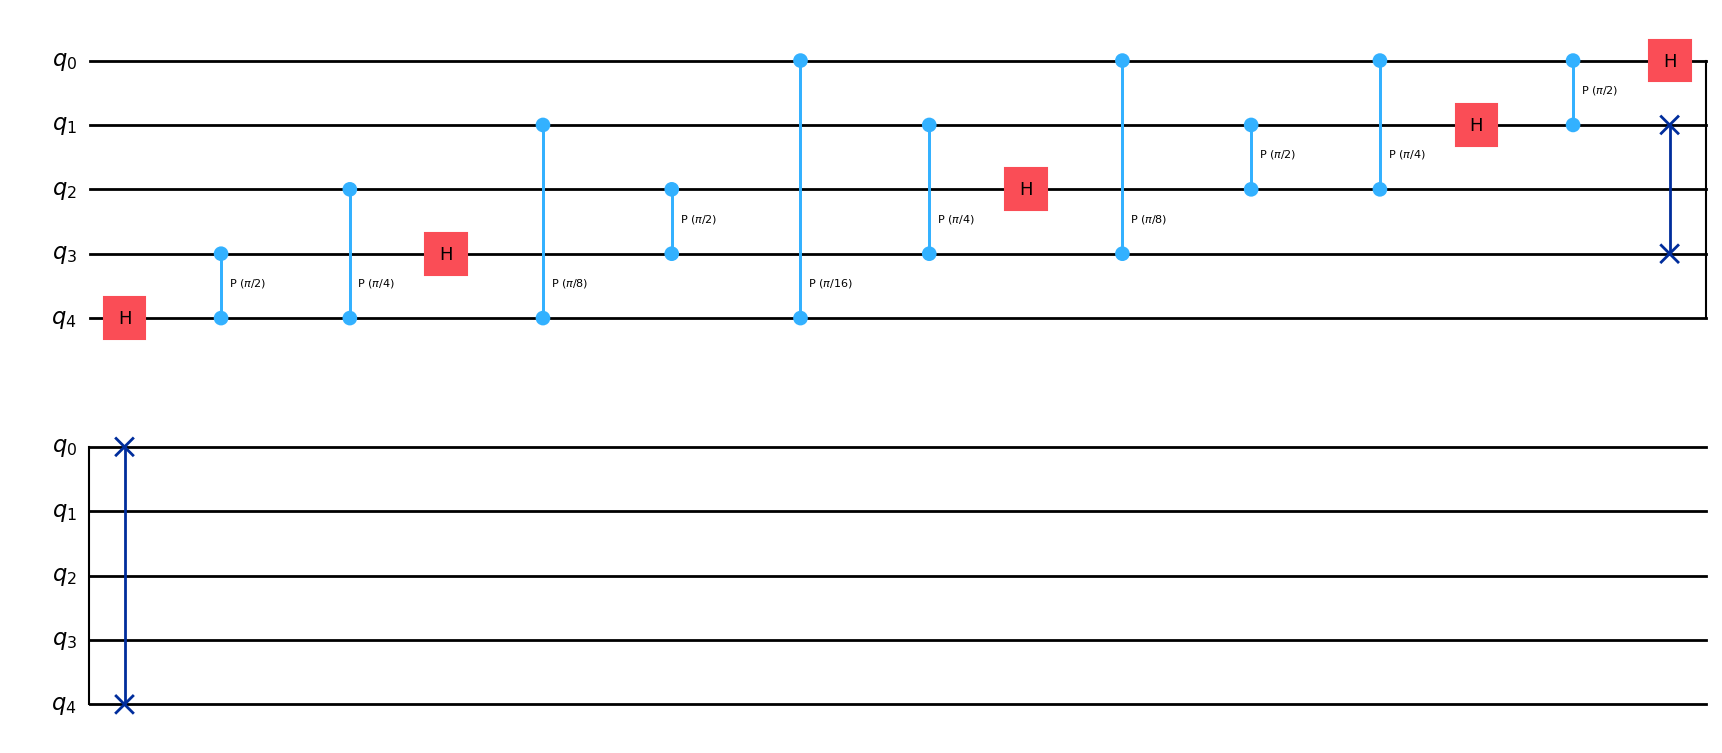

In [26]:
# First, it is actually easier and more convenient to implement an N register QFT

def QFT(N):
    qc = QuantumCircuit(N)
    for i in np.arange(N-1, -1, -1):
        qc.h(i)
        for j in range(i-1, -1, -1):
            qc.append(R(i-j+1).control(),[i,j])
    for i in range(N//2):
        qc.swap(i, N-i-1)
    return qc

QFT(5).draw(output='mpl')

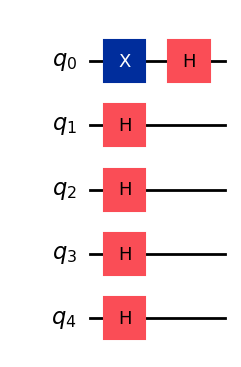

In [27]:
# Next, let's notice the kets are
# |phi1> = |+>|+>|+>|+>|->
# |phi2> = |+>|+>|+>|->|+>
# |phi3> = |+>|+>|->|+>|+>
# |phi4> = |+>|->|+>|+>|+>
# So it will be easiest to prepare the initial states with Hadamard gates as follows:


def phi(n):
    qc = QuantumCircuit(5)
    qc.x(n)
    for i in range(5):
        qc.h(i)
    return qc

phi(0).draw(output='mpl')

In [28]:
# Next we must create a 5-register QFT gate
qft5 = QFT(5).to_gate()
# And apply it to each prepared state

prec = 2 # Decimal precision
phihat_q = np.empty((4, 32), dtype=np.cdouble)
ket_q = []
for k in range(4):
    qc = phi(k)
    # Quantum Fourier transform
    qc.append(qft5, range(5))
    phihat_q[k] = Statevector(qc)
    # Format ket as a linear combination of basis vectors (string)
    idx = np.where(np.abs(phihat_q[k]) > 10**-prec)
    ket_q.append('+'.join([f'({phihat_q[k][j]:.{prec}f})|{j}>' for j in idx[0]]))

# Print out Fourier transformed kets
ket_q

['(1.00+0.00j)|16>',
 '(0.50+0.50j)|8>+(0.50-0.50j)|24>',
 '(0.25+0.60j)|4>+(0.25+0.10j)|12>+(0.25-0.10j)|20>+(0.25-0.60j)|28>',
 '(0.12+0.63j)|2>+(0.12+0.19j)|6>+(0.12+0.08j)|10>+(0.12+0.02j)|14>+(0.12-0.02j)|18>+(0.12-0.08j)|22>+(0.12-0.19j)|26>+(0.12-0.63j)|30>']

Let $QFT_5$ be the quantum Fourier transform of 5 qubits, we obtained the following results:
- $QFT_5|\phi_1\rangle = |16⟩$
- $QFT_5|\phi_2\rangle = \frac{1}{2}(1+i)|8⟩+\frac{1}{2}(1-i)|24⟩$
- $QFT_5|\phi_3\rangle = (0.25+0.60i)|4⟩+(0.25+0.10 i)|12⟩+(0.25-0.10 i) |20⟩ + (0.25-0.60i)|28⟩$
- $QFT_5|\phi_4\rangle = (0.12+0.63i)|2⟩+(0.12+0.19i)|6⟩+(0.12+0.08i)|10⟩+(0.12+0.02i)|14⟩+(0.12-0.02i)|18⟩+(0.12-0.08i)|22⟩+(0.12-0.19i)|26⟩+(0.12-0.63i)|30⟩$

The QFT is so efficient because the number of quantum gates it requires for $n$ qubits scales like $O(n^2)$, whereas the dimension of the Hilbert space scales like $N=2^n$. This can be compared to best DFT algorithm, the Fast Fourier Transform (FFT), which has complexity $O(N\log N)=O(n2^n)$ &mdash; that is, the QFT has an exponential advantage over the classical DFT. 

We could also check whether we obtain the same result via classical computing methods (bearing in mind that the convention for Fourier / inverse Fourier transform in signal processing is opposite that of quantum computing).

In [29]:
phihat_c = np.empty((4, 32), dtype=np.cdouble)
ket_c = []
for k in range(4):
    qc = phi(k)
    # Classical Fourier transform
    phihat_c[k] = np.fft.ifft(Statevector(qc), norm='ortho')
    # Format ket as a linear combination of basis vectors (string)
    idx = np.where(np.abs(phihat_c[k]) > 10**-prec)
    ket_c.append('+'.join([f'({phihat_c[k][j]:.{prec}f})|{j}>' for j in idx[0]]))

# Print out Fourier transformed kets
ket_c

['(1.00+0.00j)|16>',
 '(0.50+0.50j)|8>+(0.50-0.50j)|24>',
 '(0.25+0.60j)|4>+(0.25+0.10j)|12>+(0.25-0.10j)|20>+(0.25-0.60j)|28>',
 '(0.12+0.63j)|2>+(0.12+0.19j)|6>+(0.12+0.08j)|10>+(0.12+0.02j)|14>+(0.12-0.02j)|18>+(0.12-0.08j)|22>+(0.12-0.19j)|26>+(0.12-0.63j)|30>']

Looks promising! Just so our eyes don't deceive us, let's compare both calculations programatically.

In [30]:
np.max(np.abs(phihat_q - phihat_c))

3.3306690738754696e-16

As we can see, the discrepancy between both calculations is at most on the order of $10^{-16}$, which could be attributed to machine error.